In [1]:
# 对一张3d图片进行测试

import SimpleITK as sitk
import os

image = sitk.ReadImage('/home/tianyu/Desktop/data_base/final_data/data/DATA_100.nrrd')
nda = sitk.GetArrayFromImage(image)

z_dim, y_dim, x_dim = nda.shape

output_dir = 'output_slices'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

for i in range(z_dim):
    slice_2d = nda[i, :, :]
    
    slice_2d_image = sitk.GetImageFromArray(slice_2d)
    
    sitk.WriteImage(slice_2d_image, os.path.join(output_dir, 'slice_{:03d}.nrrd'.format(i)))

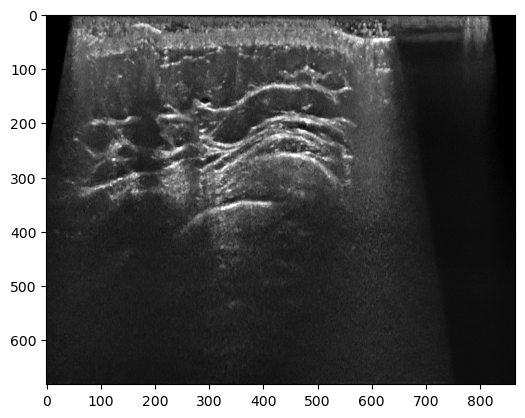

In [2]:
# 展示一张图片的结果

import SimpleITK as sitk

image_2d = sitk.ReadImage('output_slices/slice_000.nrrd')

nda_2d = sitk.GetArrayFromImage(image_2d)

import matplotlib.pyplot as plt

plt.imshow(nda_2d, cmap='gray')
plt.show()



In [3]:
import SimpleITK as sitk
import os
import numpy as np

def save_slices(nda, base_filename, output_dir):

    z_dim, y_dim, x_dim = nda.shape

    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    for i in range(z_dim):
        slice_2d = nda[i, :, :]
        
        slice_2d_image = sitk.GetImageFromArray(slice_2d)
        
        filename = os.path.join(output_dir, '{}_{:03d}.nrrd'.format(base_filename, i))
        
        sitk.WriteImage(slice_2d_image, filename)


In [8]:
image_dir = '/home/tianyu/Desktop/data_base/Init_data/DATA'
mask_dir = '/home/tianyu/Desktop/data_base/Init_data/MASK'
output_image_dir = '/media/tianyu/fanty/output_slices/xy/DATA'
output_mask_dir = '/media/tianyu/fanty/output_slices/xy/MASK'

image_filenames = os.listdir(image_dir)

for image_filename in image_filenames:

    if not image_filename.endswith('.nrrd'):
        continue
        
    
    
    data_filename = os.path.splitext(image_filename)[0]
    mask_filename = data_filename.replace("DATA", "MASK", 1)
    
    image = sitk.ReadImage(os.path.join(image_dir, image_filename))
    image_filename = image_filename.replace("DATA", "MASK", 1)
    mask = sitk.ReadImage(os.path.join(mask_dir, image_filename))
    
    nda_image = sitk.GetArrayFromImage(image)
    nda_mask = sitk.GetArrayFromImage(mask)
    
    save_slices(nda_image, data_filename, output_image_dir)
    save_slices(nda_mask, mask_filename, output_mask_dir)